## Alexander Reeves, UNE COSC102 Data Science Assessment 2
#### areeve28@myune.edu.au
#### Plant Classification

This project aims to train a computer on a dataset so that it can predict the site of a Cobra Lily plant 
when given two variables

This project uses Python and the Scikit-Learn library, and can be run by pressing play on this page
when loaded within a Jupyter Notebook.

There is also an acompanying PDF report, and video walkthrough.kthrough."

#### 1. Load the dataset and partition the dataset in the train and test sets.

In [3]:
#Import the relevant libraries for this project

import pandas as pd #Pandas to load and handle the dataset
import numpy as np #Python number library

from sklearn.neighbors import KNeighborsClassifier #Machine learning algorythm
from sklearn.model_selection import train_test_split #Split our training and testing data
from sklearn.metrics import confusion_matrix #Confusion Matrix Library
from sklearn.metrics import ConfusionMatrixDisplay #Display libraries for above CM
from sklearn.metrics import accuracy_score #Checks the accuracy of our predictor
from sklearn import preprocessing #Prepares our data for manipulation and use
from sklearn.model_selection import cross_val_score #Accuracy of the classifier
from sklearn.model_selection import cross_val_predict #Prediction tools
from sklearn.metrics import roc_auc_score #Roc Auc Score

#Other classification scoring tools
from sklearn.metrics import precision_score, recall_score, f1_score
#Visual plotting libaries
import matplotlib.pyplot as plt
from matplotlib.colors import *
#Alternative auto reporting tool for scores
from sklearn.metrics import classification_report



In [4]:
#Load the dataset

#Use pandas to load and handle the csv file
data = pd.read_csv("./data/Plants_Dataset.csv")
#Display a preview of the data contained in this set
data.head()

,Site,height,mouth_diam,tube_diam,keel_diam,wingspread,hoodarea,wingarea,tubearea,tubemass_g,wingmass_g,Ca_ppm,P_ppm,K_ppm,Mg_ppm,C_pct,H_pct,N_pct
0,TJH,654,38.4,16.6,6.4,55,63.77,33.65,87.15,3.54,0.29,717.90,997.12,10699.50,1983.40,49.43,5.50,0.93
1,TJH,413,22.2,17.2,5.9,60,21.10,7.36,44.78,1.48,0.06,392.74,876.99,9576.49,1540.73,50.24,5.63,0.94
2,TJH,610,31.2,19.9,6.7,78,28.47,15.75,56.64,2.20,0.16,402.45,1287.62,11738.73,1514.21,50.77,5.58,1.08
3,TJH,546,34.4,20.8,6.3,95,48.82,30.47,76.31,2.95,0.24,497.16,662.55,11173.37,1399.24,50.27,5.67,0.88
4,TJH,665,30.5,20.4,6.6,30,29.48,11.33,100.22,3.36,0.08,504.48,1115.53,7017.39,1964.15,50.20,5.56,0.98


In [5]:
#A handy function to check our data for Nan values that should be cleaned
def check_NaN(dataframe):
    print("Total NaN:", dataframe.isnull().values.sum())
    #print("NaN by column:\n",dataframe.isnull().sum())
    return

#In this case, our data comes ready to use.
check_NaN(data)

Total NaN: 0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Site        80 non-null     object 
 1   height      80 non-null     int64  
 2   mouth_diam  80 non-null     float64
 3   tube_diam   80 non-null     float64
 4   keel_diam   80 non-null     float64
 5   wingspread  80 non-null     int64  
 6   hoodarea    80 non-null     float64
 7   wingarea    80 non-null     float64
 8   tubearea    80 non-null     float64
 9   tubemass_g  80 non-null     float64
 10  wingmass_g  80 non-null     float64
 11  Ca_ppm      80 non-null     float64
 12  P_ppm       80 non-null     float64
 13  K_ppm       80 non-null     float64
 14  Mg_ppm      80 non-null     float64
 15  C_pct       80 non-null     float64
 16  H_pct       80 non-null     float64
 17  N_pct       80 non-null     float64
dtypes: float64(15), int64(2), object(1)
memory usage: 11.4+ KB


In [7]:
#We are trying to make predictinons for the Site column
#Set the data target to the Site column
#data.target = data.Site
targets = data['Site']

#All the other columns are currently features, though soon
#the best features will be selected
#data.features = data.drop(['Site'],axis=1)
feature_df = data.drop(['Site'],axis=1)

#Set our data into a training and testing split
x_train, x_test, y_train, y_test = train_test_split(data.features, data.target,
                                                    test_size=0.2,random_state=3)

#Process the data to the right format for the KNN classifier
data.features = preprocessing.MinMaxScaler().fit_transform(data.features)

C:\Users\reeve\AppData\Local\Temp\ipykernel_12052\2942119713.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.target = data.Site
C:\Users\reeve\AppData\Local\Temp\ipykernel_12052\2942119713.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.features = data.drop(['Site'],axis=1)


#### 2. Select the 2 most higher-performing features based upon cross-validation carried out on the training dataset.

In [9]:
#Determining the best data columns to use for our classifier

#A list of our available data columns for processing
columns = data.columns

#Keeping track of our best results so far, based on the comparisons made
best_accuracy = 0
best_f1 = 0
best_f2 = 0

#Loop through all features and compare each 2 feature combinations results
#Column 1 is the site, which is being skipped as it is the target
for f1 in range(1,len(columns)):
    for f2 in range(1,len(columns)):
        #Ensure we are comparing two different data columns, exit if they are the same
        if f1 == f2:
            continue
        #Set the columns from our data to use in this check
        data.features = data[[columns[f1],columns[f2]]]
        print("comparing features " , f1, " and " , f2, ".")

        #Test against multiple K values, for increased accuracy.
        k_scores = []
        #The K can go all the way to 73, though this increases the processing time
        #Instead I opted to use all data with n_neighbours up to 5 for speed
        #(for the time being)
        for k in range(1,5):
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn,data.features,data.target,cv=10,scoring='accuracy')
            k_scores.append(scores)

        #The optimal K result found for these two classes
        optimal_k = np.argmax(k_scores)  
        #print("Best K Score Found: ", np.argmax(k_scores))
        #A failsafe to ensure we don't run a classifier with a K of 0
        if optimal_k == 0:
            continue

        #Run the classifier with optimal K
        classifier = KNeighborsClassifier(optimal_k)
        classifier.fit(x_train, y_train)
        predictions = classifier.predict(x_test)

        #Check the accuracy
        accuracy = accuracy_score(y_test, predictions)*100
        #print("Accuracy:", accuracy)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_f1 = f1
            best_f2 = f2

print("Best accuracy: ", best_accuracy, ". Feature A: ", best_f1, ". Feature 2: ", best_f2, ".")

comparing features  1  and  2 .
comparing features  1  and  3 .
comparing features  1  and  4 .
comparing features  1  and  5 .
comparing features  1  and  6 .
comparing features  1  and  7 .
comparing features  1  and  8 .
comparing features  1  and  9 .
comparing features  1  and  10 .
comparing features  1  and  11 .
comparing features  1  and  12 .
comparing features  1  and  13 .
comparing features  1  and  14 .
comparing features  1  and  15 .
comparing features  1  and  16 .
comparing features  1  and  17 .
comparing features  2  and  1 .
comparing features  2  and  3 .
comparing features  2  and  4 .
comparing features  2  and  5 .
comparing features  2  and  6 .
comparing features  2  and  7 .
comparing features  2  and  8 .
comparing features  2  and  9 .
comparing features  2  and  10 .
comparing features  2  and  11 .
comparing features  2  and  12 .
comparing features  2  and  13 .
comparing features  2  and  14 .
comparing features  2  and  15 .
comparing features  2  and

In [64]:
#Pick the chosen columns out of the data

#Get the column titles as a text array
column_titles = list(data.columns.values)
data.features = data[[column_titles[best_f1],column_titles[best_f2]]]

#We can now see a preview of the two columns selected by the classificatin tests
print("The selected columns are ",column_titles[best_f1], " and " , column_titles[best_f2])

#The data has a Site column that is strings instead of 
#Using ints as shown in the lecture examples
#The column can be converted to ints via this function
data['Site_int'] = pd.factorize(data.Site)[0]

#Set our target to be the new column
data.target = data.Site_int

#Prepare the data
data.features = preprocessing.MinMaxScaler().fit_transform(data.features)

#Create our official Train and Test splits now that our features have been chosen
x_train, x_test, y_train, y_test = train_test_split(data.features,data.target, test_size=0.2,random_state=3)

print(data.head() , data.features)

The selected columns are  keel_diam  and  hoodarea
  Site  height  mouth_diam  tube_diam  keel_diam  wingspread  hoodarea  \
0  TJH     654        38.4       16.6        6.4          55     63.77   
1  TJH     413        22.2       17.2        5.9          60     21.10   
2  TJH     610        31.2       19.9        6.7          78     28.47   
3  TJH     546        34.4       20.8        6.3          95     48.82   
4  TJH     665        30.5       20.4        6.6          30     29.48   

   wingarea  tubearea  tubemass_g  wingmass_g  Ca_ppm    P_ppm     K_ppm  \
0     33.65     87.15        3.54        0.29  717.90   997.12  10699.50   
1      7.36     44.78        1.48        0.06  392.74   876.99   9576.49   
2     15.75     56.64        2.20        0.16  402.45  1287.62  11738.73   
3     30.47     76.31        2.95        0.24  497.16   662.55  11173.37   
4     11.33    100.22        3.36        0.08  504.48  1115.53   7017.39   

    Mg_ppm  C_pct  H_pct  N_pct  Site_int  
0  

In [11]:
#A more thorough check on K scores with the updated data.
k_scores = []

#K was only checked up to 5 when determining which features to use,
#but now that we have made a decision, a more thorough check can be made without
#Spending too much time processing.
for k in range(1,5):
    knn = KNeighborsClassifier(n_neighbors=k)
    #Cv value is the amout of folds (divide the data into 10 folds)
    #Each fold is tested against the 9 remaining sections which are used for training
    scores = cross_val_score(knn,data.features,data.target,cv=10,scoring='accuracy')
    #Get the average score from the 10 tests, and add it to the K_scores
    k_scores.append(scores.mean())

#Find the highest value in the K_scores array
optimal_k = np.argmax(k_scores)    
print("Optimal k with cross-validation: ", np.argmax(k_scores))  

Optimal k with cross-validation:  2


In [12]:
#Refresh our classifier to use the optimal features, and optimal K!
classifier = KNeighborsClassifier(optimal_k)
classifier.fit(x_train, y_train)
predictions = classifier.predict(x_test)

## 3.Construct a confusion matrix based on the classifiers performance on the test set and use this to calculate the recall, precision and F1 scores for each class.

Text(0.5, 1.0, '3-Fold Testing')

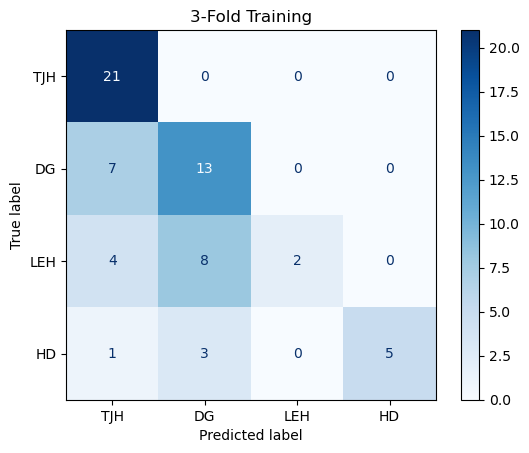

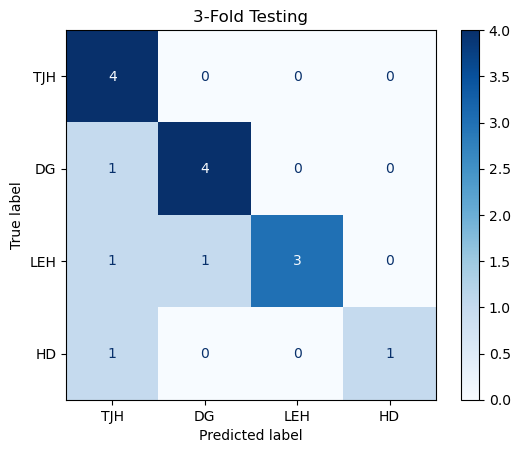

In [14]:
#Create the confusion matrix
#Get the unique site names that our site int's correspond to
target_list = data['Site'].unique()

# Plot the confusion matrices for the training data
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_estimator(classifier, x_train, y_train,
                                 display_labels=target_list,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('3-Fold Training')

# Plot the confusion matrices for the test data
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay.from_estimator(classifier, x_test, y_test,
                                 display_labels=target_list,
                                 cmap=plt.cm.Blues,ax=ax)
ax.set_title('3-Fold Testing')

In [15]:
###########           TJH
#Get the true false for each test item being site TJH

y_test_TJH = (y_test == 0)
#Get the items that are predicted as TJH by the classifier
predictions_TJH = (predictions == 0)
#We now have an array for TJH test items, and TJH predictions
precision_TJH = (precision_score(y_test_TJH, predictions_TJH))*100
recall_TJH = (recall_score(y_test_TJH, predictions_TJH))*100
f1_TJH = (f1_score(y_test_TJH, predictions_TJH))*100

#################      DG

#Get the true false for each test item being site DG
y_test_DG = (y_test == 1)
#Get the items that are predicted as DG by the classifier
predictions_DG = (predictions == 1)
precision_DG = (precision_score(y_test_DG, predictions_DG))*100
recall_DG = (recall_score(y_test_DG, predictions_DG))*100
f1_DG = (f1_score(y_test_DG, predictions_DG))*100

#################      LEH

#Get the true false for each test item being site LEH
y_test_LEH = (y_test == 2)
#Get the items that are predicted as LEH by the classifier
predictions_LEH = (predictions == 2)
precision_LEH = (precision_score(y_test_LEH, predictions_LEH))*100
recall_LEH = (recall_score(y_test_LEH, predictions_LEH))*100
f1_LEH = (f1_score(y_test_LEH, predictions_LEH))*100

################       HD

#Get the true false for each test item being site HD
y_test_HD = (y_test == 3)
#Get the items that are predicted as HD by the classifier
predictions_HD = (predictions == 3)
precision_HD = (precision_score(y_test_HD, predictions_HD))*100
recall_HD = (recall_score(y_test_HD, predictions_HD))*100
f1_HD = (f1_score(y_test_HD, predictions_HD))*100



print("Precision Score\n")
print("The precision score tells us the percent of positive predictions, that were correct")
print("TJH Precision score   : ", precision_TJH, "%")
print("DG Precision score    : ", precision_DG, "%")
print("LEH Precision score   : ", precision_LEH, "%")
print("HD Recall score       : ", precision_HD, "%")

print("\nRecall Score\n")
print("The recall score tells us..........")
print("TJH Recall score      : ", recall_TJH, "%")
print("DG Recall score       : ", recall_DG, "%")
print("LEH Recall score      : ", recall_LEH, "%")
print("HD Recall score       : ", recall_HD, "%")

print("\nF1 Score\n")
print("The F1 score tells us .............")
print("TJH F1 score          : ", f1_TJH, "%")
print("DG F1 score           : ", f1_DG, "%")
print("LEH F1 score          : ", f1_LEH, "%")
print("HD F1 score           : ", f1_HD, "%")

Precision Score

The precision score tells us the percent of positive predictions, that were correct
TJH Precision score   :  57.14285714285714 %
DG Precision score    :  80.0 %
LEH Precision score   :  100.0 %
HD Recall score       :  100.0 %

Recall Score

The recall score tells us..........
TJH Recall score      :  100.0 %
DG Recall score       :  80.0 %
LEH Recall score      :  60.0 %
HD Recall score       :  50.0 %

F1 Score

The F1 score tells us .............
TJH F1 score          :  72.72727272727273 %
DG F1 score           :  80.00000000000001 %
LEH F1 score          :  74.99999999999999 %
HD F1 score           :  66.66666666666666 %


In [16]:
#I Also came across this auto-reporter which does a full calculation for all these details in a neat little graph!
#You can reference the results above to confirm that both outputs are reaching the same conclusions

print(classification_report(y_test, predictions, target_names=target_list, output_dict= False))

              precision    recall  f1-score   support

         TJH       0.57      1.00      0.73         4
          DG       0.80      0.80      0.80         5
         LEH       1.00      0.60      0.75         5
          HD       1.00      0.50      0.67         2

    accuracy                           0.75        16
   macro avg       0.84      0.72      0.74        16
weighted avg       0.83      0.75      0.75        16



In [17]:
#Construct a ROC curve for each class and calculate the respective AUC values

#I chose to use the roc training data as it was a larger sample size
#And in theory should still show a representation of the same result
y_train_TJH = (y_train == 0)
y_train_DG = (y_train == 1)
y_train_LEH = (y_train == 2)
y_train_HD = (y_train == 3)

#Apply the cross val predict so we can get the
#precisions, recalls and thresholds
y_scores_TJH = cross_val_predict(classifier, x_train, y_train_TJH, cv=3)
y_scores_DG = cross_val_predict(classifier, x_train, y_train_DG, cv=3)
y_scores_LEH = cross_val_predict(classifier, x_train, y_train_LEH, cv=3)
y_scores_HD = cross_val_predict(classifier, x_train, y_train_HD, cv=3)


#Function to create the plot and load data
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

#### 4. Construct a ROC curve for each class and calculate the respective AUC values

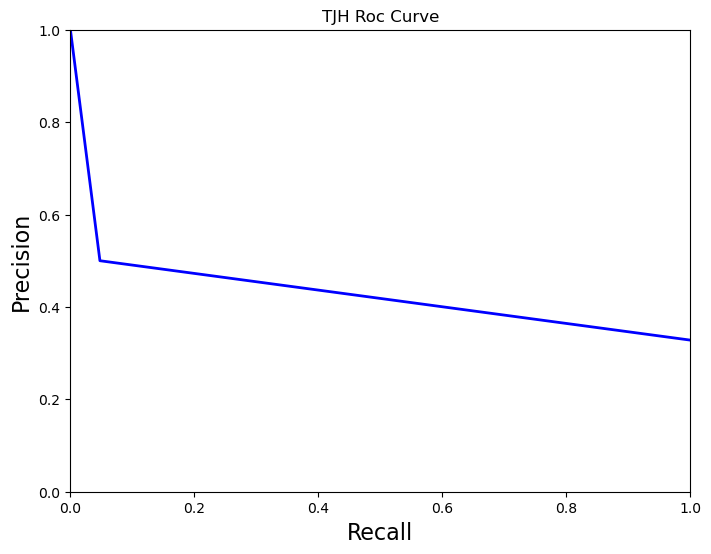

In [19]:
#TJH Roc Curve plotting
from sklearn.metrics import precision_recall_curve
precisions_TJH, recalls_TJH, thresholds_TJH = precision_recall_curve(y_train_TJH, y_scores_TJH)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_TJH, recalls_TJH)
plt.title("TJH Roc Curve")
plt.show()

In [20]:
print("The Roc AUC score for the TJH class is:")
roc_auc_score(y_train_TJH, y_scores_TJH)

The Roc AUC score for the TJH class is:


0.5121816168327796

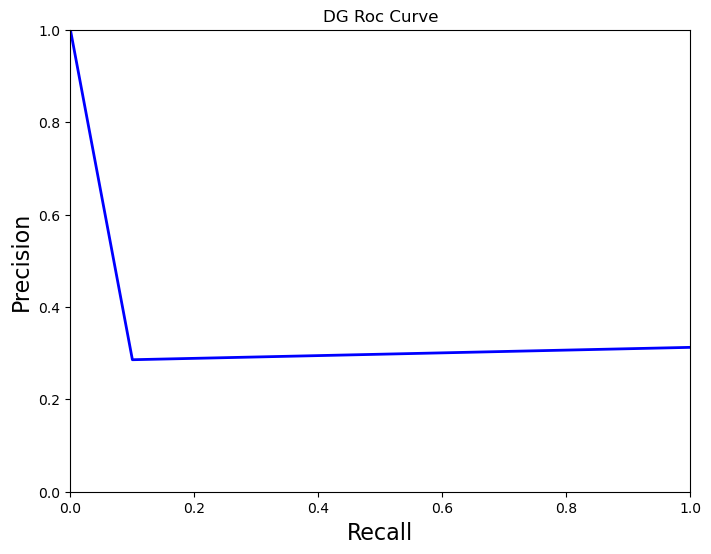

In [21]:
#Roc Curve
precisions_DG, recalls_DG, thresholds_DG = precision_recall_curve(y_train_DG, y_scores_DG)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_DG, recalls_DG)
plt.title("DG Roc Curve")
plt.show()

In [22]:
print("The Roc AUC score for the DG class is:")
roc_auc_score(y_train_DG, y_scores_DG)

The Roc AUC score for the DG class is:


0.4931818181818182

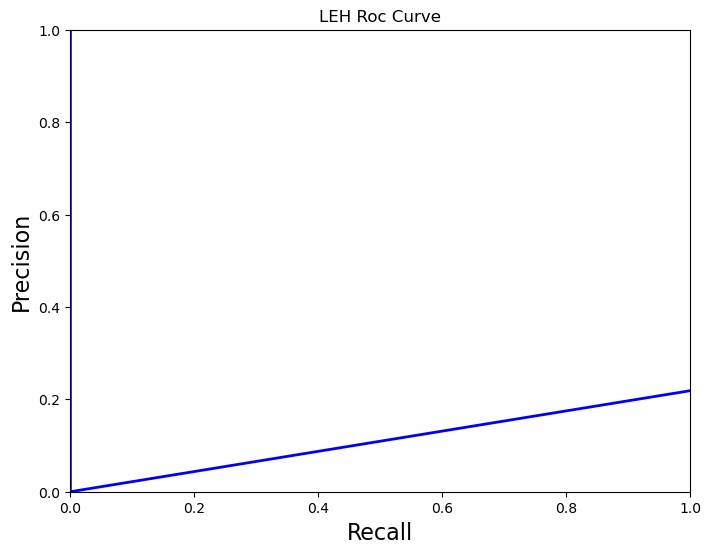

In [23]:
#Roc Curve
precisions_LEH, recalls_LEH, thresholds_LEH = precision_recall_curve(y_train_LEH, y_scores_LEH)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_LEH, recalls_LEH)
plt.title("LEH Roc Curve")

plt.show()

In [24]:
print("The Roc AUC score for the LEH class is:")
roc_auc_score(y_train_LEH, y_scores_LEH)

The Roc AUC score for the LEH class is:


0.48

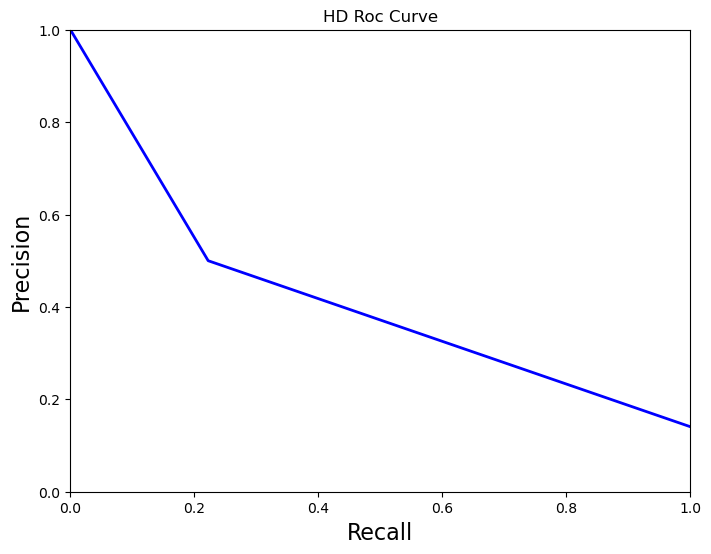

In [25]:
#Roc Curve
precisions_HD, recalls_HD, thresholds_HD = precision_recall_curve(y_train_HD, y_scores_HD)
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_HD, recalls_HD)
plt.title("HD Roc Curve")
plt.show()

In [26]:
print("The Roc AUC score for the HD class is:")
roc_auc_score(y_train_HD, y_scores_HD)

The Roc AUC score for the HD class is:


0.592929292929293

#### 5. Construct a suitable visualisation that demonstrates the decision boundaries learned by the classifier on the features...

C:\Users\reeve\AppData\Local\Temp\ipykernel_12052\537367376.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xs[ys==j,0],xs[ys==j,1],


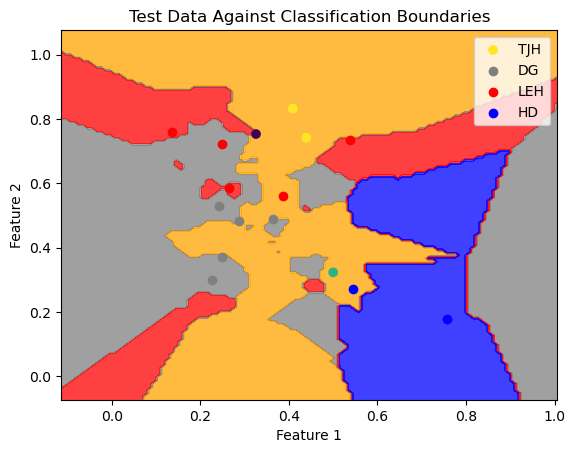

In [70]:
#Load prediction boundaries and test data into a matplotlib graph
xs, ys = x_test, y_test

#Create the mesh based on the max and min values that our data uses
X1, X2 = np.meshgrid(np.arange(start = xs[:,0].min() - 0.25,stop = xs[:,0].max() + 0.25,step = 0.01),
                     np.arange(start = xs[:,1].min() - 0.25,stop = xs[:,1].max() + 0.25,step = 0.01))

#Show the boundaries via the respective colour
plt.contourf(X1,X2, classifier.predict(np.array([X1.ravel(),X2.ravel()]).T).reshape(X1.shape),
            alpha = 0.75, cmap = ListedColormap(['orange','grey','red','blue']))

plt.xlim(X1.min(),X1.max())
plt.ylim(X2.min(),X2.max())

#Load each test data set
for i, j in enumerate(np.unique(ys)):
    plt.scatter(xs[ys==j,0],xs[ys==j,1],
                c=ListedColormap(['orange','grey','red','blue'])(i),label = target_list[j])
plt.title('Test Data Against Classification Boundaries')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
#Done!

In [76]:
print(ys)

61    2
57    2
77    3
6     0
45    1
8     0
35    1
73    3
9     0
59    2
12    0
27    1
34    1
63    2
47    1
54    2
Name: Site_int, dtype: int64
